# Average energy for each interaction type

## Classes and functions

In [3]:
from __future__ import print_function, division
import sys
sys.path.append('../src')
sys.path.append('../script')

import numpy as np
import math
import time
import torch
from torch.utils.data import DataLoader, random_split
from data_classes import RNASeqDataset, LocalEnergyOpt
from my_script import get_target, loss_fn, train, test
from sklearn import decomposition, manifold
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from LocalEnergyVct import assign_thetatype, assign_phitype

In [4]:
def extract_bonds(features,lengths):
    
    btypes = []
    for i in range(len(features)):
        atom = features[i,:lengths[i,0],0].squeeze().long()    
        btype = features[i,:lengths[i,6],6].squeeze().long().view(-1,3)
        btype[:,:2] = (btype[:,:2]/3).long()
        btype[:,2] -= 1    
        btypes.append(btype)
        
    return btypes


def bonds_energy(coords, bonds, bond_type):
    
    a1 = bonds[:,0]
    a2 = bonds[:,1]
    idx = bonds[:,2]
    d = coords[a1,:]-coords[a2,:]
    d = torch.linalg.norm(d, dim=1)
    energy = bond_type[idx,0]*(d-bond_type[idx,1])**2
    
    return energy


def create_bondmatrix_line(coords, bonds, bond_type):
    
    energy = bonds_energy(coords, bonds, bond_type)
    bdict = {key: [] for key in np.arange(0,11)}
    for i,en in enumerate(energy):
        key = bonds[i,2].item()
        bdict[key].append(en)
    
    matrix_line = torch.zeros(11)
    for j in bdict.keys():
        matrix_line[j] = sum(bdict[j])/len(bdict[j]) if len(bdict[j]) != 0 else 0
        
    return matrix_line

# ------------------------------------------------------------------------------------

def extract_angles(features,lengths):
    
    atypes = []
    thetas = []

    for i in range(len(features)):
        atom = features[i,:lengths[i,0],0].squeeze().long()    
        atype = features[i,:lengths[i,7],7].squeeze().long().view(-1,4)
        atype[:,:3] = (atype[:,:3]/3).long()
        atype[:,3] -= 1    
        theta = assign_thetatype(atom,atype[:,0],atype[:,1],atype[:,2])
        atypes.append(atype)
        thetas.append(theta)
        
    return atypes, thetas


def angles_energy(thetatype, coords, angles, angle_type, pars):

    a1 = angles[:,0]
    a2 = angles[:,1]
    a3 = angles[:,2]
    idx = angles[:,3]

    rij = coords[a1,:] - coords[a2,:]
    rkj = coords[a3, :] - coords[a2, :]
    an = torch.acos((rij*rkj).sum(dim=1) / (torch.linalg.norm(rij, dim=1) * torch.linalg.norm(rkj, dim=1)))
    energy = pars[thetatype+1] * angle_type[idx, 0] * (an - angle_type[idx, 1])**2

    return energy


def create_anglematrix_line(thetatype, coords, angles, angle_type, pars):
    
    energy = angles_energy(thetatype, coords, angles, angle_type, pars)
    adict = {key: [] for key in np.arange(0,12)}
    for i,en in enumerate(energy):
        key = angles[i,3].item()
        adict[key].append(en)
    
    matrix_line = torch.zeros(12)
    for j in adict.keys():
        matrix_line[j] = sum(adict[j])/len(adict[j]) if len(adict[j]) != 0 else 0
        
    return matrix_line


# ------------------------------------------------------------------------------------

def extract_torsions(features,lengths):
    
    ttypes = []
    phis = []

    for i in range(len(features)):
        atom = features[i,:lengths[i,0],0].squeeze().long()    
        ttype = features[i,:lengths[i,8],8].squeeze().long().view(-1,5)
        ttype[:,:4] = (ttype[:,:4]/3).long()
        ttype[:,4] -= 1    
        phi = assign_phitype(atom,ttype[:,0],ttype[:,1],ttype[:,2],ttype[:,3])
        ttypes.append(ttype)
        phis.append(phi)
        
    return ttypes, phis


def torsions_energy(phitype, coords, tors, tors_type, mult, pars):

    a1 = tors[:,0]
    a2 = tors[:,1]
    a3 = tors[:,2]
    a4 = tors[:,3]
    idx = tors[:,4]

    rij = coords[a1,:] - coords[a2,:]
    rkj = coords[a3, :] - coords[a2, :]
    rkl = coords[a3, :] - coords[a4, :]
    nj = torch.linalg.cross(rij, rkj, dim=1)
    nj = nj / torch.linalg.norm(nj, dim=1).unsqueeze(1).expand(-1,3)
    nk = torch.linalg.cross(rkl, rkj, dim=1)
    nk = nk / torch.linalg.norm(nk,dim=1).unsqueeze(1).expand(-1,3)
    phi = torch.acos((nj*nk).sum(dim=1))
    phi = math.pi - phi*torch.sign((rkj*torch.linalg.cross(nk, nj, dim=1)).sum(dim=1))
    energy = pars[28+phitype] * tors_type[idx, 0] * (1+torch.cos(mult[idx]*phi - tors_type[idx, 1]))
    
    return energy


def create_torsionmatrix_line(phitype, coords, tors, tors_type, mult, pars):
    
    energy = torsions_energy(phitype, coords, tors, tors_type, mult, pars)
    tdict = {key: [] for key in np.arange(0,25)}
    for i,en in enumerate(energy):
        key = tors[i,4].item()
        tdict[key].append(en)
    
    matrix_line = torch.zeros(25)
    for j in tdict.keys():
        matrix_line[j] = sum(tdict[j])/len(tdict[j]) if len(tdict[j]) != 0 else 0
        
    return matrix_line

In [20]:
dataset = RNASeqDataset().dataset
features = dataset['features']
lengths = dataset['lengths']
print(features.shape, lengths.shape)

model = LocalEnergyOpt()
model.load_state_dict(torch.load("../results/Results_fixedLR/300_b16_e4_Aso.pth"))

bond_pars = model.bond_type.data
angle_pars = model.angle_type.data
torsion_pars = model.tor_type.data
mult = model.multiplicity.data
dat_pars = model.opt_pars.data

coords = [features[i,:lengths[i,5],5].squeeze().view(-1,3) for i in range(len(features))]
atoms = [features[i,:lengths[i,0],0].squeeze().long() for i in range(len(features))]
bonds_amber = features[:,0,9].squeeze()
angles_amber = features[:,1,9].squeeze()
torsions_amber = features[:,2,9].squeeze()

bmean = bonds_amber.mean()
amean = angles_amber.mean()
tmean = torsions_amber.mean()

print(bonds_amber.mean(), angles_amber.mean(), torsions_amber.mean())

torch.Size([1638, 445, 10]) torch.Size([1638, 10])
tensor(12.5656) tensor(37.8729) tensor(176.2083)


In [6]:
bonds = extract_bonds(features,lengths)
bond_matrix = torch.zeros(len(features),11)
for i in range(len(features)):
    bond_matrix[i] = create_bondmatrix_line(coords[i], bonds[i], bond_pars)

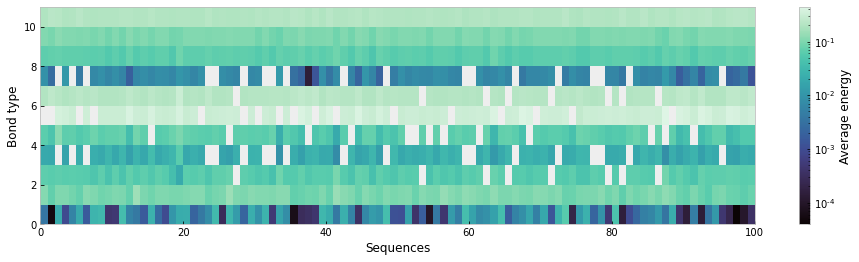

In [7]:
fig = plt.figure(figsize=(16,4))
data = bond_matrix[:100].transpose(1,0)
heatmap = plt.pcolormesh(data, cmap="mako", norm=LogNorm())
cbar = plt.colorbar(heatmap)
plt.xlabel("Sequences")
plt.ylabel("Bond type")
cbar.ax.set_ylabel("Average energy", rotation=90)
plt.show()

In [8]:
angle_matrix = torch.zeros(len(features),12)
angles, thetas = extract_angles(features, lengths)
for i in range(len(features)):
    angle_matrix[i] = create_anglematrix_line(thetas[i], coords[i], angles[i], angle_pars, dat_pars)

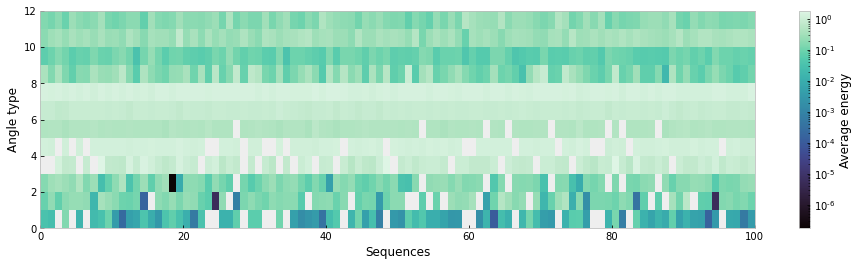

In [9]:
fig = plt.figure(figsize=(16,4))
data = angle_matrix[:100].transpose(1,0)
heatmap = plt.pcolormesh(data, cmap="mako", norm=LogNorm())
cbar = plt.colorbar(heatmap)
plt.xlabel("Sequences")
plt.ylabel("Angle type")
cbar.ax.set_ylabel("Average energy", rotation=90)
plt.show()

In [10]:
torsions, phis = extract_torsions(features,lengths)
torsion_matrix = torch.zeros(len(features),25)
for i in range(len(features)):
    torsion_matrix[i] = create_torsionmatrix_line(phis[i], coords[i], torsions[i], torsion_pars, mult, dat_pars)

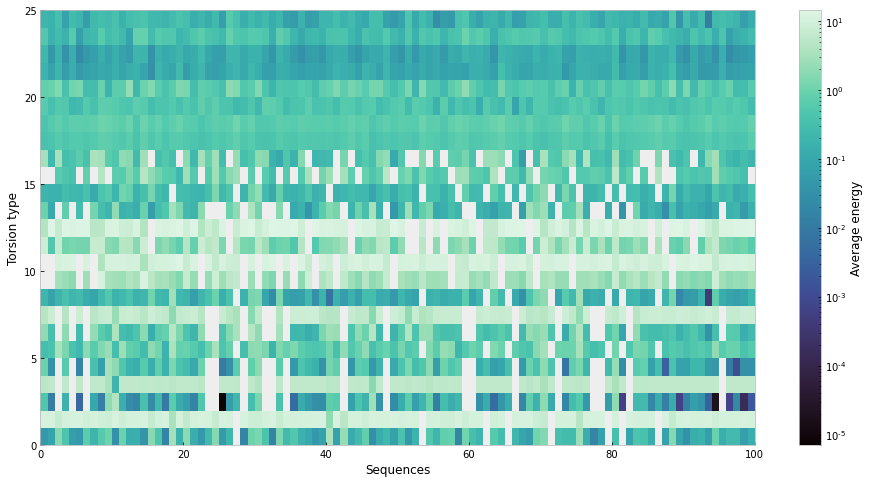

In [11]:
fig = plt.figure(figsize=(16,8))
data = torsion_matrix[:100].transpose(1,0)
heatmap = plt.pcolormesh(data, cmap="mako", norm=LogNorm())
cbar = plt.colorbar(heatmap)
plt.xlabel("Sequences")
plt.ylabel("Torsion type")
cbar.ax.set_ylabel("Average energy", rotation=90)
plt.show()

[7.08794574e-01 1.98706085e-01 3.87568772e-02 2.12322217e-02
 1.09613245e-02 1.05641973e-02 4.60191968e-03 3.05419795e-03
 2.49520811e-03 6.32109172e-04 2.01285770e-04]


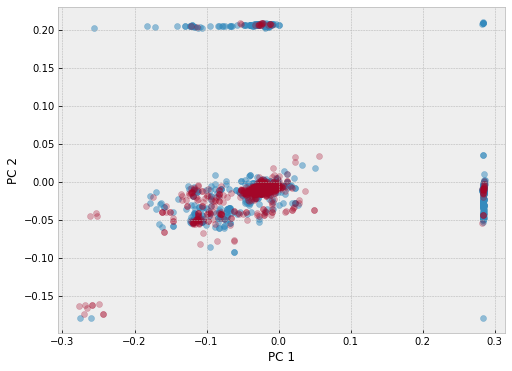

In [24]:
pca = decomposition.PCA()
bonds_pca = pca.fit_transform(bond_matrix)
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(bonds_pca[bonds_amber<bmean,0], bonds_pca[bonds_amber<bmean,1], alpha=0.5)
ax.scatter(bonds_pca[bonds_amber>=bmean,0], bonds_pca[bonds_amber>=bmean,1], alpha=0.3)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

print(pca.explained_variance_ratio_)

[0.46075809 0.28922515 0.11409569 0.03838038 0.02572246 0.0197041
 0.01584975 0.01304521 0.01226361 0.00519389 0.00324294 0.00251873]


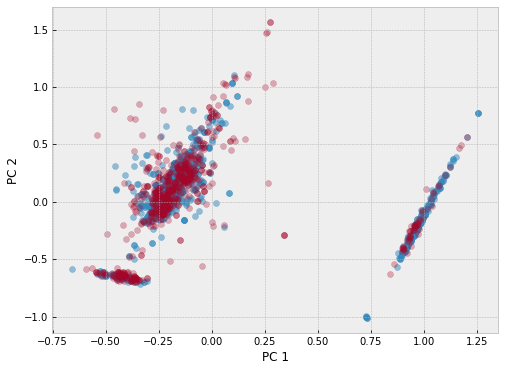

In [23]:
pca = decomposition.PCA()
angles_pca = pca.fit_transform(angle_matrix)
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(angles_pca[angles_amber<amean,0], angles_pca[angles_amber<amean,1], alpha=0.5)
ax.scatter(angles_pca[angles_amber>=amean,0], angles_pca[angles_amber>=amean,1], alpha=0.3)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

print(pca.explained_variance_ratio_)

[3.02550874e-01 1.99172489e-01 1.69528948e-01 1.32444096e-01
 7.62067042e-02 5.81140948e-02 2.81102086e-02 1.23574705e-02
 5.40807534e-03 3.12403703e-03 2.77608214e-03 2.48672932e-03
 1.82609411e-03 1.59778595e-03 1.23382632e-03 9.53481066e-04
 5.47079405e-04 4.79569920e-04 4.32469728e-04 3.64111813e-04
 1.45101305e-04 9.23570945e-05 3.81299134e-05 7.09938694e-06
 3.08474444e-06]


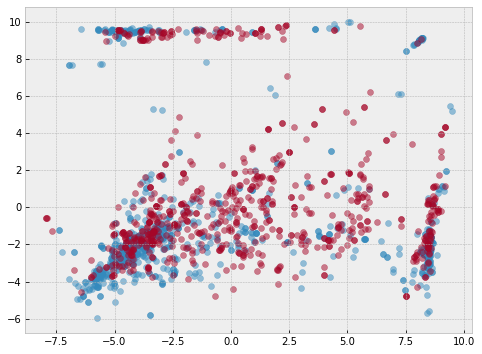

In [25]:
pca = decomposition.PCA()
torsions_pca = pca.fit_transform(torsion_matrix)
fig = plt.figure(figsize=(8,6))
plt.scatter(torsions_pca[torsions_amber<tmean,0], torsions_pca[torsions_amber<tmean,1], alpha=0.5)
plt.scatter(torsions_pca[torsions_amber>=tmean,0], torsions_pca[torsions_amber>=tmean,1], alpha=0.3)

print(pca.explained_variance_ratio_)